# Sinkhorns autoencoder 

implementation by @KamilDeja (github) https://github.com/KamilDeja/e2e_sinkhorn_autoencoder/blob/main/MNIST_simple_example.ipynb

In [1]:
!pip install geomloss

You should consider upgrading via the 'E:\Users\qesterius\Documents\Studia\Wizualizacja_duzych_zbiorow_danych\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch.nn as nn
import torch.nn.functional as F
from geomloss import SamplesLoss
import torch

class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim):
        super(Autoencoder, self).__init__()
        self.d = 64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d)
        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d)
        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear(self.d*9, self.d//4)

        self.fc1 = nn.Linear(self.d//4, self.d*4)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 4, 2, 0, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d*4)
        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 4, 2, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d*2)
        self.dc3 = nn.ConvTranspose2d( self.d * 2, self.d , 4, 1, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(self.d)
        self.dc4 = nn.ConvTranspose2d( self.d , 1, 4, 2, 0, bias=False)    
        

############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d*2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d)
        self.ng_fc2 = nn.Linear(self.d*3, self.d*4)
        self.ng_fc3 = nn.Linear(self.d*4, self.d*3)
        self.ng_fc4 = nn.Linear(self.d*3, self.d//4)
############

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    
    # forward method
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(self.bn_1(x))
        x = self.conv2(x)
        x = F.leaky_relu(self.bn_2(x))
        x = self.conv3(x)
        x = F.leaky_relu(self.bn_3(x))
        x = x.view([-1,self.d*9])
        y = self.fc3(x)

        x = F.leaky_relu(self.fc1(y))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x = F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x)), y
    
    def generate(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x =F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x))
    
    def generate_noise(self, x, cond_x): 
        x = F.leaky_relu(self.ng_fc1(x), 0.2)
        x2 = F.leaky_relu(self.ng_input_2(cond_x), 0.2)
        x_concat = torch.cat((x,x2),1)
        x = F.leaky_relu(self.ng_fc2(x_concat), 0.2)
        x = F.leaky_relu(self.ng_fc3(x), 0.2)
        x = self.ng_fc4(x)
        return x

# FMNIST dataset

In [ ]:
!pip install torchvision

(60000, 784)
(60000,)
(10000, 784)
(10000,)


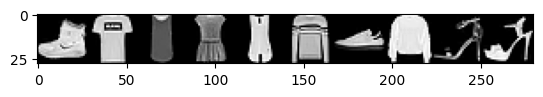

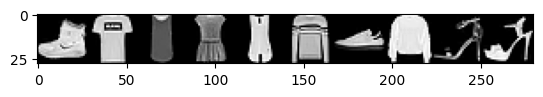

In [3]:
from torchvision.datasets import FashionMNIST

train = FashionMNIST("",download=True,train=True)
test = FashionMNIST("",download=True,train=False)


X_train, y_train = train.data, train.targets
X_test, y_test = test.data, test.targets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#show first 10 images 
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')
plt.show()

#normalize data
import torch

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')
plt.show()


# Training

In [4]:
n_classes = 10
input_size = 28*28
autoencoder = Autoencoder(input_size, n_classes)

In [5]:
import torch.optim as optim

criterion_mse = nn.MSELoss() #reconstruction loss
loss_func = SamplesLoss("sinkhorn", blur=0.05,scaling = 0.95,diameter=0.01,debias=True)
lr = 0.0001
a_optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ExponentialLR(a_optimizer, gamma = 0.95)
batch_size = 64


In [6]:
print(max(y_train), min(y_train))

9 0


In [7]:
print(X_train.shape)
print(y_train.shape)

torch.Size([60000, 784])
(60000,)


In [8]:
X_train = torch.Tensor(X_train).view(-1,1,28,28)
y_train = torch.Tensor(y_train)
y_train = y_train.type(torch.int64)

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
print(len(train_loader))

937


E:\Users\qesterius\AppData\Local\Temp\ipykernel_11296\1586784932.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  y_train = torch.Tensor(y_train)


BELOW IS JUST PASTED....

In [9]:
n_epoch = 50
a_weigth = 1000
ng_weigth = 1 

autoencoder.train()
for epoch in range(1, n_epoch+1):      
    ng_losses = []
    a_losses = []
    mse_losses = []
    l2_loss = []
    for batch_idx, (x, cond_x) in enumerate(train_loader):
        y_onehot = torch.FloatTensor(batch_size, 10)
        y_onehot.zero_()
        
        cond_x = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1)
        
        autoencoder.zero_grad()

        autoencoder_output, y = autoencoder(x)
        
        ### STANDARD AUTOENCODER MSE loss
        a_loss_mse = criterion_mse(autoencoder_output, x)
        
        rand_x = torch.rand(batch_size, input_size) ### Generate input noise for the noise generator
        rand_y = autoencoder.generate_noise(rand_x,cond_x) ### Generate noise from random vector and conditional params
        #`print(x.shape,y.shape, cond_x.shape, rand_y.shape, cond_x.shape)
        ng_loss = loss_func(torch.cat([y,cond_x],1), torch.cat([rand_y,cond_x],1)) ### noise generator losss, 
            #conditional params added to compute also loss for generating noise close to this from other conditionals

        s_loss = ng_weigth*ng_loss+ a_weigth*a_loss_mse
        s_loss.backward()
        
        a_optimizer.step()
        a_losses.append(a_loss_mse)
        ng_losses.append(ng_loss)

    print('[%d/%d]: loss_ng: %.4f, loss_a: %.4f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(ng_losses)), torch.mean(torch.FloatTensor(a_losses))))#, torch.mean(torch.FloatTensor(mse_losses)), torch.mean(torch.FloatTensor(l2_loss))))
    scheduler.step()
#     print("lr:",scheduler.get_lr())

[1/50]: loss_ng: 0.5293, loss_a: 0.0245
[2/50]: loss_ng: 0.2694, loss_a: 0.0148
[3/50]: loss_ng: 0.2407, loss_a: 0.0134
[4/50]: loss_ng: 0.2180, loss_a: 0.0125
[5/50]: loss_ng: 0.2020, loss_a: 0.0120
[6/50]: loss_ng: 0.1896, loss_a: 0.0116
